# Reinforcement Learning

**Goal:** Model the Emotion Task behavioral data using Q-Learning<br>
**Date:** June - July 2023


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import nest_asyncio
nest_asyncio.apply()
import multiprocessing
multiprocessing.set_start_method("fork")
import arviz
# custom functions
from rl_utils import select_session

ModuleNotFoundError: No module named 'rl_utils'

***
## Import Session

#### Select session to model

In [102]:
from rl_utils import select_session
# Set paths
ROOT = '/Users/rahimhashim/Google Drive/My Drive/Columbia/Salzman/Monkey-Training/'
VIDEO_ROOT = os.path.join(ROOT, 'tasks', 'rhAirpuff', '8. Probabilistic_Reward_Airpuff_Choice', 'videos')
SESSION_ROOT = os.path.join(ROOT, 'data', 'processed', 'processed_Probabilistic_Reward_Airpuff_Choice')

# Select session
DATE = '230626'
MONKEY = 'Aragorn'

session_df = select_session(SESSION_ROOT, DATE, MONKEY, correct_only=False)
session_df['block_change'] = session_df['block'].diff().fillna(0)
session_df_correct = session_df[session_df['correct'] == 1]
session_df_choice = session_df_correct[session_df_correct['choice_trial'] == 1]

# set a new field for valence not chosen
def valence_field(trial):
  """Generate valence field for session"""
  valence_left = trial['valence_1']
  valence_right = trial['valence_2']
  valence_chosen = trial['valence']
  if valence_chosen == valence_left:
    valence_not_chosen = valence_right
  else:
    valence_not_chosen = valence_left
  trial['valence'] = valence_chosen
  trial['valence_not_chosen'] = valence_not_chosen
  return trial

session_df_choice = session_df_choice.apply(valence_field, axis=1)

def action_field(trial):
  """Generate action field for session"""
  valence_left = trial['valence_1']
  valence_right = trial['valence_2']
  valence_chosen = trial['valence']

  action = 0
  if valence_left > valence_right:
    if valence_chosen == valence_left:
      action = 1
    else:
      action = 0
  elif valence_left < valence_right:
    if valence_chosen == valence_right:
      action = 1
    else:
      action = 0
  trial['action'] = action
  return trial

session_df_choice = session_df_choice.apply(action_field, axis=1)

actions = session_df_choice['action'].values
rewards = session_df_choice['reward'].values
valences = session_df_choice['valence'].values
valences_not_chosen = session_df_choice['valence_not_chosen'].values
# larger of the two valences
valences_max = np.maximum(valences, valences_not_chosen)
session_df_choice['valences_max'] = valences_max
# smaller of the two valences
valences_min = np.minimum(valences, valences_not_chosen)
session_df_choice['valences_min'] = valences_min

Selecting session: 230626_Aragorn


/var/folders/8z/8tf_3z4d0_1cgj07xk0dtqq00000gn/T/ipykernel_91043/1236640582.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_df_choice['block_change'] = session_df_choice['block'].diff().fillna(0)


In [106]:
# set max rows to None
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
session_df_correct[['stimuli_name_1', 'stimuli_name_2', 'fractal_chosen']]

,stimuli_name_1,stimuli_name_2,fractal_chosen
0,_fractal_B,_fractal_B,_fractal_B
1,_fractal_C,_fractal_C,_fractal_C
2,_fractal_A,_fractal_A,_fractal_A
4,_fractal_E,_fractal_D,_fractal_D
7,_fractal_A,_fractal_A,_fractal_A
...,...,...,...
683,_fractal_D,_fractal_D,_fractal_D
685,_fractal_D,_fractal_D,_fractal_D
687,_fractal_B,_fractal_D,_fractal_D
689,_fractal_D,_fractal_D,_fractal_D


## I. Simulate two-choise task data with 5 states based on RL updating rule 


## $$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha(R+ \gamma \max_aQ(s_{t+1}, a) - Q(s_t, a_t))$$

### A two-choice decision making task

### 1. The reward is given based on $p$, with 5 possible magnitudes
$p$: The probability of getting a reward<br>
$m$: The magnitude of reward ([2, 1, 0, -1, -2])

### 2. Action-State value $Q(s,a)$ update: Q-learning


#### 2.1. Define the states: 
  There are four states $s_0$ for this task. All you need to make a decision no matter what timestep you are. 

 So you only need to know: $Q(s=s_0, a)$

####  $$Q(s_0,a_t) \leftarrow Q(s_0,a_t) + \alpha(R  - Q(s_0, a_0))$$

#### 2.2. Action-selection policy 
There are two possible actions: choose large or choose small

Given the $Q$-value ($Q(s,a)$), you need to choose a action $a_i$ based on Softmax function: 

#### $$P(a_i| s_0) = \frac{-\beta\exp(Q(a_i,s_0))}{\sum_j \exp( -\beta Q(a_j,s_0))}$$


### 3. The data should include States and actions
We want the states, actions during the learning process, which is similar as the $Q$-value update process. 

***
## Simulate behavioral task

### 5 states with pre-assigned reward outcomes

| State   | Outcome (Pre-) | Outcome (Post-)|
|  :---        |    :----:      |         :---:  |
| __fractal_A_ |       2        |      -1        |
| __fractal_B_ |       1        |      -2        |
| __fractal_C_ |       0        |       0        |
| __fractal_D_ |       -1       |       2        |
| __fractal_E_ |       -2       |       1        |

### Two Possible Trial Types
**Reinforcement Trials**
- 1 fractal presented with central fixation point
- Monkey must hold fixation until Delay Period, after which he receives outcome
- Reinforcement only (no choice)

**Choice Trials**
- 2 fractals presented simultaneously
- Monkey must hold fixation until Choice Period, followed by Delay Period, after which he receives outcome for chosen fractal

### To Do:
**Update Action Policy**
- attempt 1: only update Q for chosen action
- attempt 2: update Q for chosen action, update Q for not-chosen action with small decay (i.e. gamma)
**Multiply Learning Rates**
- Potentially add alpha for large vs. small 

In [155]:
import random
from scipy import optimize
import threading
from collections import defaultdict

cs_list = ['_fractal_A', '_fractal_B', '_fractal_C', '_fractal_D', '_fractal_E']
r_table_preswitch = {'_fractal_A': 2, '_fractal_B': 1, '_fractal_C': 0, '_fractal_D': -1, '_fractal_E': -2}
p_r_table_preswitch = {'_fractal_A': 1, '_fractal_B': 1, '_fractal_C': 1, '_fractal_D': 0.5, '_fractal_E': 1}
r_table_postswitch = {'_fractal_A': -1, '_fractal_B': -2, '_fractal_C': 0, '_fractal_D': 2, '_fractal_E': 1}
p_r_table_postswitch = {'_fractal_A': 0.5, '_fractal_B': 1, '_fractal_C': 1, '_fractal_D': 1, '_fractal_E': 1}

# get values from jet colormap
cmap = plt.cm.jet_r
colors = cmap(np.linspace(0, 1, len(set(cs_list))))
color_keys = sorted(set(cs_list), reverse=True)
color_dict = dict(zip(color_keys, colors))

def generate_data_4choice(cs_list, cs_pairs_list, alpha, beta, gamma=None, n=100, verbose=True):
  # array of actions and rewards
  actions = []
  rewards = []
  action_prob = []
  choice_trials = []

  # create a table store the update process of q-value, which has two actions, four states.
  Qs = defaultdict(list)
  for cs in cs_list:
    Qs[cs] = np.zeros(n)

  # Print parameters
  if verbose:
    print(f'  alpha: {alpha}, beta: {beta}, gamma: {gamma}')

  # Simulate cs_pairs_list
  if cs_pairs_list is None:

    for i in np.arange(1, n): # for n-steps learning(q-value updating)

      # Probability of choice trial
      choice_trial = random.random() < 0.25

      # Choice Trial -- 2 CS, choose 1
      if choice_trial:

        # Randomly select 2 CS from cs_list
        cs_pair = np.random.choice(cs_list, 2, replace=False)
        cs_pairs_list.append(cs_pair)
        choice_trials.append(1)

      else:
        # Reinforcement trial -- 1 CS, forced choice
        cs_pair = np.random.choice(cs_list, 1)[0]
        cs_pairs_list.append([cs_pair, np.nan])
        choice_trials.append(0)

  else:
    choice_trials = [1 if cs_pair[1] is not np.nan else 0 for cs_pair in cs_pairs_list]
    
  print(f'Simulating {n} trials...')

  for i in np.arange(1, n): # for n-steps learning(q-value updating)

    # Get CS pair
    cs_pair = cs_pairs_list[i-1]
    
    if choice_trials[i] == 1:

      # Get Q-values for each CS
      Q_1 = Qs[cs_pair[0]][i-1]
      Q_2 = Qs[cs_pair[1]][i-1]

      prob_a_q1 = np.exp(-beta*Q_1)/(np.sum(np.exp(-beta*Q_1 + np.exp(-beta*Q_2))))
      prob_a_q2 = np.exp(-beta*Q_2)/(np.sum(np.exp(-beta*Q_1 + np.exp(-beta*Q_2))))

      # Simulate choice based on prob_a
      choice = random.random()
      if choice < 1 - prob_a_q1:
        a = cs_pair[0]
        Q = Q_1
      else:
        a = cs_pair[1]  
        Q = Q_2

      action_prob.append(prob_a_q1)
    
    # Reinforcement trial -- 1 CS, forced choice
    else:
      a = cs_pair[0]
      Q = Qs[a][i-1]

    # calculate reward for action based on r_table
    p_r = random.random()
    if i < switch_trial:
      r_table = r_table_preswitch
      p_r_table = p_r_table_preswitch
    else:
      r_table = r_table_postswitch
      p_r_table = p_r_table_postswitch

    # Simulate reward based on p_r, and action
    if p_r < p_r_table[a]:
        r = r_table[a]
    else:
      r = 0

    # Update Q table for chosen action
    Qs[a][i] = Q + alpha * (r - Q)

    # Update values for all non-chosen actions
    for cs in cs_list:
      if cs != a:
        # No forgetting rate
        if gamma is None:
          Qs[cs][i] = Qs[cs][i-1]
        # With forgetting rate
        else:
          Qs[cs][i] = Qs[cs][i-1] * gamma

    # Store values
    actions.append(a)
    rewards.append(r)

  print('Done!')
  return cs_pairs_list, actions, action_prob, rewards, Qs

# try alpha values from 0.1 to 1.0
alpha_list = np.arange(0.1, 1.1, 0.1)
# try beta values from -10 to 10
beta_list = np.arange(-10, 11, 1)
# try gamma values from 0.1 to 1.0
gamma_list = np.arange(0.8, 1.1, 0.5)

def parameter_grid_search(cs_pairs_list, alpha_list, beta_list, gamma_list, num_trials, switch_trial):
  paramter_df = pd.DataFrame(columns=['alpha', 'beta', 'gamma', 'cs_pairs_list', 'actions', 'action_prob', 'rewards', 'Qs'])
  # thread process to run the simulation
  def run_simulation(paramter_df, cs_pairs_list, alpha, beta, gamma, num_trials, switch_trial):
    cs_pairs_list, actions, action_prob, rewards, Qs = generate_data_4choice(cs_list, cs_pairs_list, alpha, beta, gamma, num_trials, verbose=True)
    paramter_df.loc[len(paramter_df)] = [alpha, beta, gamma, cs_pairs_list, actions, action_prob, rewards, Qs]

  threads = []
  # run the simulation for each parameter combination
  for alpha in alpha_list:
    for beta in beta_list:
      for gamma in gamma_list:
          thread = threading.Thread(target=run_simulation, args=(paramter_df, cs_pairs_list, alpha, beta, gamma, num_trials, switch_trial))
          threads += [thread]
          thread.start()
  for thread in threads:
    thread.join()  # makes sure that the main program waits until all threads have terminated

  return paramter_df

try:
  cs_pairs_list = list(zip(session_df_correct['stimuli_name_1'].tolist(), session_df_correct['stimuli_name_2'].tolist()))
  actions = session_df_correct['fractal_chosen'].tolist()
  num_trials = len(cs_pairs_list)
  switch_trial = np.diff(session_df_correct['block'].values).nonzero()[0][0]
  print('Using session data...')
  print(f'  num_trials: {num_trials}, switch_trial: {switch_trial}')
except:
  print('No cs_pairs_list found, randomizing new cs_pairs_list...')
  cs_pairs_list = None
  actions = None
  # number of trials
  num_trials = 200
  switch_trial = num_trials/2

# run the grid search
parameter_df = parameter_grid_search(cs_pairs_list, alpha_list[0:1], beta_list[0:1], gamma_list[0:1], num_trials, switch_trial)
# sort by alpha, then beta, then gamma, in reverse order
parameter_df = parameter_df.sort_values(by=['alpha', 'beta', 'gamma'], ascending=False, ignore_index=True)

parameter_estimate = parameter_df.actions.tolist()[0] + [0]
performance_model = [1 if parameter_estimate[i]  == actions[i] else 0 for i in range(len(actions))]
print(f'Performance: {np.sum(performance_model)/len(performance_model)}')

Using session data...
  num_trials: 420, switch_trial: 199
  alpha: 0.1, beta: -10, gamma: 0.8
Simulating 420 trials...
Done!


In [158]:
parameter_df.actions.tolist()

[['_fractal_B',
  '_fractal_C',
  '_fractal_A',
  '_fractal_E',
  '_fractal_A',
  '_fractal_D',
  '_fractal_B',
  '_fractal_D',
  '_fractal_D',
  '_fractal_A',
  '_fractal_B',
  '_fractal_D',
  '_fractal_A',
  '_fractal_B',
  '_fractal_E',
  '_fractal_E',
  '_fractal_B',
  '_fractal_B',
  '_fractal_E',
  '_fractal_D',
  '_fractal_A',
  '_fractal_D',
  '_fractal_C',
  '_fractal_A',
  '_fractal_E',
  '_fractal_A',
  '_fractal_B',
  '_fractal_D',
  '_fractal_D',
  '_fractal_C',
  '_fractal_E',
  '_fractal_E',
  '_fractal_B',
  '_fractal_A',
  '_fractal_B',
  '_fractal_E',
  '_fractal_E',
  '_fractal_A',
  '_fractal_E',
  '_fractal_C',
  '_fractal_C',
  '_fractal_D',
  '_fractal_A',
  '_fractal_E',
  '_fractal_B',
  '_fractal_E',
  '_fractal_A',
  '_fractal_E',
  '_fractal_C',
  '_fractal_E',
  '_fractal_D',
  '_fractal_B',
  '_fractal_B',
  '_fractal_E',
  '_fractal_B',
  '_fractal_B',
  '_fractal_D',
  '_fractal_C',
  '_fractal_B',
  '_fractal_B',
  '_fractal_E',
  '_fractal_E',
  '_frac

***
## Plot Results

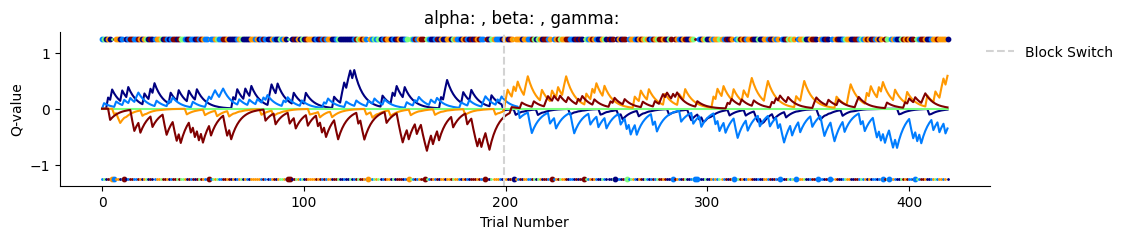

In [172]:
def plot_session(**kwargs):
  cs_pairs_list = kwargs['cs_pairs_list']
  actions = kwargs['actions']
  Qs = kwargs['Qs']
  alpha = kwargs['alpha']
  beta = kwargs['beta']
  gamma = kwargs['gamma']
  switch_trial = kwargs['switch_trial']

  f, ax = plt.subplots(figsize=(12,2))
  
  # plot Qs for each cs
  for cs in Qs.keys():
    plt.plot(Qs[cs], color=color_dict[cs], label=cs)

  # get max abs value of Qs
  max_abs = np.max(np.abs([Qs[cs] for cs in Qs.keys()])) + 0.5

  # size of chosen scatter
  s_chosen = 10
  s_not_chosen = 1

  # plot scatter of each trial cs pair and action
  for i in range(len(cs_pairs_list)):
    cs_pair = cs_pairs_list[i]
    cs_1 = cs_pair[0]
    cs_2 = cs_pair[1]
    action = actions[i]
    if i < switch_trial:
      r_table = r_table_preswitch
    else:
      r_table = r_table_postswitch
    # reinforcement trial
    if cs_2 is np.nan:
      plt.scatter(i, max_abs, marker='o', color=color_dict[cs_1], s=s_chosen)
    # choice trial: cs_1 > cs_2
    elif r_table[cs_1] > r_table[cs_2]:
      if action == cs_1:
        s1 = s_chosen
        s2 = s_not_chosen
      else:
        s1 = s_not_chosen
        s2 = s_chosen
      plt.scatter(i, max_abs, marker='o', color=color_dict[cs_1], s=s1)
      plt.scatter(i, -1*max_abs, marker='o', color=color_dict[cs_2], s=s2)
    # choice trial: cs_2 > cs_1
    else:
      if action == cs_2:
        s2 = s_chosen
        s1 = s_not_chosen
      else:
        s2 = s_not_chosen
        s1 = s_chosen
      plt.scatter(i, max_abs, marker='o', color=color_dict[cs_2], s=s2)
      plt.scatter(i, -1*max_abs, marker='o', color=color_dict[cs_1], s=s1)

  plt.axvline(x=switch_trial, c='lightgrey', linestyle='--', label='Block Switch')
  plt.xlabel('Trial Number')
  plt.ylabel('Q-value')
  # turn off splines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  # legend outside of plot with no borders
  plt.legend(bbox_to_anchor=(0.99, 0.95), loc='upper left', borderaxespad=0., frameon=False)
  # set title as alpha, beta, gamma
  plt.title(f'alpha: {alpha}, beta: {beta}, gamma: {gamma}')
  plt.show()

cs_pairs_list = list(zip(session_df_correct['stimuli_name_1'].tolist(), session_df_correct['stimuli_name_2'].tolist()))
actions = session_df_correct['fractal_chosen'].tolist()
Qs = parameter_df.Qs.tolist()[0]
alpha = ''
beta = ''
gamma = ''
switch_trial = np.diff(session_df_correct['block'].values).nonzero()[0][0]

kwargs = {'cs_pairs_list': cs_pairs_list, 'actions': actions, 'Qs': Qs, 'alpha': alpha, 'beta': beta, 'gamma': gamma, 'switch_trial': switch_trial}

plot_session(**kwargs)

# for i in range(len(parameter_df)):
#   cs_pairs_list = parameter_df['cs_pairs_list'][i]
#   actions = parameter_df['actions'][i]
#   Qs = parameter_df['Qs'][i]
#   alpha = parameter_df['alpha'][i]
#   beta = parameter_df['beta'][i]
#   gamma = parameter_df['gamma'][i]
#   args = (cs_pairs_list, actions, Qs, switch_trial, alpha, beta, gamma)
#   plot_session(*args)

In [101]:
# make table from one row of parameter_df
Qs_df = pd.DataFrame(parameter_df['Qs'][0])
Qs_df['actions'] = parameter_df['actions'][0] + [np.nan]
Qs_df['rewards'] = parameter_df['rewards'][0] + [np.nan]

Qs_df.head(10)

,CS_1,CS_2,CS_3,CS_4,CS_5,actions,rewards
0,0.0,0.000000,0.0,0.0,0.0000,CS_2,1.0
1,0.0,0.100000,0.0,0.0,0.0000,CS_2,1.0
2,0.0,0.190000,0.0,0.0,0.0000,CS_2,1.0
3,0.0,0.271000,0.0,0.0,0.0000,CS_4,0.0
4,0.0,0.216800,0.0,0.0,0.0000,CS_3,0.0
5,0.0,0.173440,0.0,0.0,0.0000,CS_5,-2.0
6,0.0,0.138752,0.0,0.0,-0.2000,CS_5,-2.0
7,0.0,0.111002,0.0,0.0,-0.3800,CS_3,0.0
8,0.0,0.088801,0.0,0.0,-0.3040,CS_2,1.0
9,0.0,0.179921,0.0,0.0,-0.2432,CS_2,1.0


***
## PyStan Model Fitting

In [23]:
stan_qf = """
data {
  int<lower=1> T ;               // Number of trials
  int<lower=1,upper=2> a[T];     // Actions (1: Large, 2: Small)
  real r[T];                     // Rewards
}

parameters {
  real<lower=0.0,upper=1.0> alpha;    // Learning rate
  real<lower=0.0> beta;               // Inverse temperature
}

model {
  matrix[4,T] Q; // Action values
  Q[1, 1] = 0;
  Q[2, 1] = 0;
  Q[3, 1] = 0;
  Q[4, 1] = 0;
  
  // Priors
  alpha ~ beta(2, 2);
  beta ~ gamma(2, 3);
  
  // Using 'for' iteration for time-series computation
  for ( t in 1:T ) {
    // Action selection
    // Adding a log-likelihood of a predicted action to "target"
    target += log( 1.0 / ( 1.0 + exp( -beta * (Q[a[t],t] - Q[3-a[t],t]) ) ) );
    
    // Value update
    if (t < T) {
      Q[a[t], t+1] = (1.0 - alpha) * Q[a[t], t] + alpha * r[t]; // Value update for a chosen action
    }
  }
}
"""

In [24]:
sm = pystan.StanModel(model_code = stan_qf)
#print(sm)

In file included from /var/folders/8z/8tf_3z4d0_1cgj07xk0dtqq00000gn/T/pystan_d23mff4u/stanfit4anon_model_f4b902685cd72f2a695936602e4edff2_6432412417991622494.cpp:840:
In file included from /Users/rahimhashim/miniconda3/envs/rl_oist/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/rahimhashim/miniconda3/envs/rl_oist/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/rahimhashim/miniconda3/envs/rl_oist/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/Users/rahimhashim/miniconda3/envs/rl_oist/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/8z/8tf_3z4d0_1cgj07xk0dtqq00000gn/T/pystan_d23mff4u/stanfit4anon_m

In [25]:
data_qf = {
    "T": len(actions),
    "a": actions.astype(int)+1,
    "r": rewards
}

In [26]:
sm = pystan.StanModel(model_code=stan_qf)

In file included from /var/folders/8z/8tf_3z4d0_1cgj07xk0dtqq00000gn/T/pystan_kg98_3f5/stanfit4anon_model_f4b902685cd72f2a695936602e4edff2_8532932635838896305.cpp:840:
In file included from /Users/rahimhashim/miniconda3/envs/rl_oist/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/rahimhashim/miniconda3/envs/rl_oist/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/rahimhashim/miniconda3/envs/rl_oist/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/Users/rahimhashim/miniconda3/envs/rl_oist/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/8z/8tf_3z4d0_1cgj07xk0dtqq00000gn/T/pystan_kg98_3f5/stanfit4anon_m

In [27]:
sample_kwargs = {"iter": 5000, "chains": 4, "warmup": 2000}
fit = sm.sampling(data=data_qf, **sample_kwargs)
qf_ll = np.mean(fit["lp__"])

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting ini

RuntimeError: Initialization failed.

Selecting session: 230626_Aragorn


/var/folders/8z/8tf_3z4d0_1cgj07xk0dtqq00000gn/T/ipykernel_91043/1236640582.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_df_choice['block_change'] = session_df_choice['block'].diff().fillna(0)


In [33]:
import scipy

def llik_td(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args

    # Initialize values
    Q = np.array([0.5, 0.5])
    logp_actions = np.zeros(len(actions))

    for t, (a, r) in enumerate(zip(actions, rewards)):
        # Apply the softmax transformation
        Q_ = Q * beta
        logp_action = Q_ - scipy.special.logsumexp(Q_)

        # Store the log probability of the observed action
        logp_actions[t] = logp_action[a]

        # Update the Q values for the next trial
        Q[a] = Q[a] + alpha * (r - Q[a])

    # Return the negative log likelihood of all observed actions
    return -np.sum(logp_actions[1:])

# return index of value in list
def index(val):
  return cs_list.index(val)

# convert actions to ints 0 to 5
actions_int = [index(a) for a in actions]
llik_td([0.5, 1.5], actions_int, rewards)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [41]:
import pymc as pm
import pytensor
import pytensor.tensor as pt
seed = sum(map(ord, "RL_PyMC"))
rng = np.random.default_rng(seed)
def pytensor_llik_td(alpha, beta, actions, rewards):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")

    # Compute the Qs values
    Qs = 0.5 * pt.ones((2,), dtype="float64")
    Qs, updates = pytensor.scan(
        fn=update_Q, sequences=[actions, rewards], outputs_info=[Qs], non_sequences=[alpha]
    )

    # Apply the sotfmax transformation
    Qs = Qs[:-1] * beta
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)

    # Calculate the log likelihood of the observed actions
    logp_actions = logp_actions[pt.arange(actions.shape[0] - 1), actions[1:]]
    return pt.sum(logp_actions)  # PyMC expects the standard log-likelihood

with pm.Model() as m:
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    beta = pm.HalfNormal(name="beta", sigma=10)
    
    like = pm.Potential(name="like", var=pytensor_llik_td(alpha, beta, actions_int, rewards))

    tr = pm.sample(random_seed=rng)

NameError: name 'update_Q' is not defined